In [1]:
!unzip -q /content/en-ner-conll-2003.zip -d /content/

In [2]:
import os
import pandas as pd
import gensim
from gensim.models import KeyedVectors
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.regularizers import l2
from collections import Counter
from torchtext.vocab import vocab
from tqdm.notebook import tqdm
import torch

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


### Declare path

In [3]:
data_dir_path = 'en-ner-conll-2003'
train_path = os.path.join(data_dir_path, 'train', 'train.tsv')
dev_texts_path = os.path.join(data_dir_path, 'dev-0', 'in.tsv')
dev_labels_path = os.path.join(data_dir_path, 'dev-0', 'expected.tsv')
dev_predicted_path = os.path.join(data_dir_path, 'dev-0', 'out.tsv')
test_texts_path = os.path.join(data_dir_path, 'test-A', 'in.tsv')
test_predicted_path = os.path.join(data_dir_path, 'test-A', 'out.tsv')
word2vec_file_path = 'word2vec_100_3_polish.bin'

### Load files

In [4]:
train_data = pd.read_csv(train_path, sep='\t', usecols=[0, 1], header=None, names=['label', 'text'])
dev_texts_data = pd.read_csv(dev_texts_path, sep='\t', usecols=[0], header=None, names=['text'])
dev_labels_data = pd.read_csv(dev_labels_path, sep='\t', usecols=[0], header=None, names=['label'])
test_texts_data = pd.read_csv(test_texts_path, sep='\t', usecols=[0], header=None, names=['text'])

### Build Vocab

In [5]:
def build_vocab(dataset):
    counter = Counter()
    for document in dataset:
        counter.update(document)
    return vocab(counter, specials=["<unk>", "<pad>", "<bos>", "<eos>"])

In [6]:
train_X = train_data['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
v = build_vocab(train_X)

In [7]:
itos = v.get_itos()

In [8]:
print(itos)

['<unk>', '<pad>', '<bos>', '<eos>', 'eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', 'peter', 'blackburn', 'brussels', 'the', 'european', 'commission', 'said', 'on', 'thursday', 'it', 'disagreed', 'with', 'advice', 'consumers', 'shun', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'sheep', 'germany', 'representative', 'union', 'veterinary', 'committee', 'werner', 'zwingmann', 'wednesday', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'britain', 'scientific', 'was', 'clearer', 'we', 'do', 'support', 'any', 'such', 'recommendation', 'because', 'see', 'grounds', 'for', 'chief', 'spokesman', 'nikolaus', 'van', 'der', 'pas', 'told', 'news', 'briefing', 'he', 'further', 'study', 'required', 'and', 'if', 'found', 'that', 'action', 'needed', 'taken', 'by', 'proposal', 'last', 'month', 'farm', 'commissioner', 'franz', 'fischler', 'ban', 'brains', 'spleens', 'spinal', 'cords', 'human', 'animal', 'f

In [9]:
v.set_default_index(v["<unk>"])

### Preprocess data

In [10]:
reformat_ner_dict = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [11]:
def fit_data_Y(column):
    dt = [
        [reformat_ner_dict[token] for token in row.split()] for row in column
    ]
    return [torch.tensor([0] + document + [0], dtype=torch.long) for document in dt]

def fit_data_X(dt):
    return [
        torch.tensor(
            [v["<bos>"]] + [v[token] for token in document.split()] + [v["<eos>"]],
            dtype=torch.long,
        )
        for document in dt
    ]


train_X = fit_data_X(train_data['text'])
train_Y = fit_data_Y(train_data['label'])
dev_X = fit_data_X(dev_texts_data['text'])
dev_Y = fit_data_Y(dev_labels_data['label'])
test_X = fit_data_X(test_texts_data['text'])

### Create model

In [12]:
num_tags = len(reformat_ner_dict)

In [13]:
class LSTM(torch.nn.Module):

    def __init__(self):
        super(LSTM, self).__init__()
        self.emb = torch.nn.Embedding(len(v.get_itos()), 100)
        self.rec = torch.nn.LSTM(100, 256, 1, batch_first=True)
        self.fc1 = torch.nn.Linear(256, num_tags)

    def forward(self, x):
        emb = torch.relu(self.emb(x))
        lstm_output, (h_n, c_n) = self.rec(emb)
        out_weights = self.fc1(lstm_output)
        return out_weights

In [14]:
lstm = LSTM()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())

### Evaluation model

In [15]:
def get_accuracy(y_true, y_pred):
    hit = 0
    missed = 0

    for p, t in zip(y_pred, y_true):
        if p == t:
            hit += 1
        else:
            missed += 1

    accuracy = hit / (hit + missed)
    return accuracy

In [16]:
def eval_model(dataset_tokens, dataset_labels, model):
    Y_true = []
    Y_pred = []
    for i in tqdm(range(len(dataset_labels))):
        batch_tokens = dataset_tokens[i].unsqueeze(0)
        tags = list(dataset_labels[i].numpy())
        Y_true += tags

        Y_batch_pred_weights = model(batch_tokens).squeeze(0)
        Y_batch_pred = torch.argmax(Y_batch_pred_weights, 1)
        Y_pred += list(Y_batch_pred.numpy())

    return get_accuracy(Y_true, Y_pred)

### Train model

In [22]:
NUM_EPOCHS = 100
dev_accuracy_history = list()
for i in range(NUM_EPOCHS):
    lstm.train()
    for i in tqdm(range(len(train_Y))):
        batch_tokens = train_X[i].unsqueeze(0)
        tags = train_Y[i].unsqueeze(1)

        predicted_tags = lstm(batch_tokens)

        optimizer.zero_grad()
        loss = criterion(predicted_tags.squeeze(0), tags.squeeze(1))

        loss.backward()
        optimizer.step()

    lstm.eval()
    dev_accuracy = eval_model(dev_X, dev_Y, lstm)
    dev_accuracy_history.append(dev_accuracy)
    print("dev_accuracy:", dev_accuracy)


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8253814880312118


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8272775336821571


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8288636487940055


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8296293595376566


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8295382034967457


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8261289675666806


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8233395927148092


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8254361816557583


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8291188857085559


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8282255565076297


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8284260997976336


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8291735793331024


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8304133014894897


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8287724927530947


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8272228400576106


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8259284242766768


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8301033709503929


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8318900293522452


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8309602377349546


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8275145393885253


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8292829665821954


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8277333138867112


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8284990246303623


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8304315326976719


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8267488286448743


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8274051521394323


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8274233833476144


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8282984813403584


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8308690816940438


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8321634974749776


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8278609323439864


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8294288162476527


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.826384204481231


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8301945269913037


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8305226887385827


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8314707115640554


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8291006545003737


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8289183424185521


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8299392900767534


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8310513937758656


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8308873129022261


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8304862263222184


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.831653023645877


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.830559151154947


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8280250132176259


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8291188857085559


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.831981185393156


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8316894860622414


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8291371169167381


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8292647353740132


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8296840531622031


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.830121602158575


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8324551968058923


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8317259484786057


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8326557400958962


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8298481340358426


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8332573699659076


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8299757524931177


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.834825253869574


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8307596944449509


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8290641920840094


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8288454175858234


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8292647353740132


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8293194289985597


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8281344004667189


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8313977867313267


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8272410712657928


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8286448742958196


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8293011977903776


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8289365736267342


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8287177991285483


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8273504585148858


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8285901806712731


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8298663652440247


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8284078685894514


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8279338571767151


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.830230989407668


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8311425498167764


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8319082605604273


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8324369655977102


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8309237753185904


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8289912672512807


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8305773823631292


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8278427011358043


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8313613243149623


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8255638001130335


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8272775336821571


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8278427011358043


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8237042168784525


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8291371169167381


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8268764471021495


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8277515450948935


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8281161692585368


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8263659732730488


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8299392900767534


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8283896373812693


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8274416145557966


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8283714061730871


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8262930484403201


  0%|          | 0/945 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

dev_accuracy: 0.8298116716194782


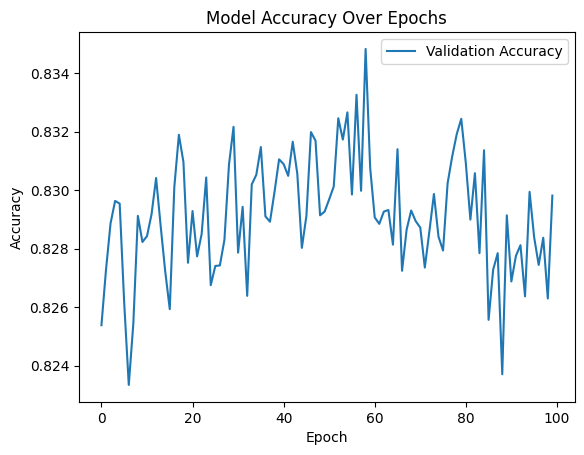

In [23]:
plt.plot(dev_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

### Predict and save results

In [24]:
reversed_ner_dict = {v: k for k, v in reformat_ner_dict.items()}
print(reversed_ner_dict)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


In [25]:
def predict_and_save(X, filename):
    Y_predicted = []
    for i in tqdm(range(len(X))):
        batch_tokens = X[i].unsqueeze(0)
        Y_batch_pred_weights = lstm(batch_tokens).squeeze(0)
        Y_batch_pred = torch.argmax(Y_batch_pred_weights, 1)
        Y_processed_pred = " ".join(reversed_ner_dict[item] for item in Y_batch_pred.numpy()[1:-1])
        Y_predicted.append(Y_processed_pred)
    Y_predicted_df = pd.DataFrame(Y_predicted, columns=['predicted_label'])
    Y_predicted_df.to_csv(filename, sep='\t', index=False, header=None)

In [26]:
dev_predicted = predict_and_save(dev_X, dev_predicted_path)
test_predicted = predict_and_save(test_X, test_predicted_path)

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]